# Predicting IMDB_SCORE Using Regression Analysis

## Importing Required Libriaries

In [1]:
import os # for performing Opersting System related analysis like viewing the contents of a folder
import numpy as np # for mathematical calculations 
import pandas as pd # for Data analysis
import matplotlib.pyplot as plt # for Plotting the data
from sklearn.model_selection import train_test_split # to split the data into train and test sets
from sklearn.metrics import f1_score, confusion_matrix # scoring metrics for classification analysis
import lightgbm as lgb #Light Gradient Bossting Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier #Tree based models for Classification Analysis
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.experimental import enable_hist_gradient_boosting # Enabling the Histogram based gradient boosting
from sklearn.ensemble import HistGradientBoostingClassifier # Histogram based gradient boosting model
from sklearn.preprocessing import MinMaxScaler # to scale the data to a particular range like (0,1)

#comment the below line to use in any IDE other than Jupyter Notebook
#Magic command to plot the figures in jupyter notebook
%matplotlib inline 

## Reading the data from csv file

In [5]:
#Using the pandas built in function read_csv to read data from csv file. It loads the data directly into a pandas dataframe
movie_metadata = pd.read_csv('movie_metadata.csv')

In [6]:
# A Function to reduce the memory usage of a pandas dataframe
# Inspired from Kaggle Kernels
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object and df[col].dtype != 'datetime64':  # Exclude strings and Datetimes           
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            #print("min for this col: ",mn)
            #print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else: 
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",df[col].dtype)
            #print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",(100*mem_usg)/start_mem_usg,"% of the initial size")
    return df, NAlist

movie_metadata, NAlist = reduce_mem_usage(movie_metadata)

Memory usage of properties dataframe is : 1.077423095703125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.7167196273803711  MB
This is  66.52165061606004 % of the initial size


In [7]:
#Checking the data samples with "head" method which gives the top rows(default 5)
movie_metadata.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,...,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000
1,Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,309404152,Action|Adventure|Fantasy,...,1238,English,USA,PG-13,300000000,2007,5000,7.1,2.35,0
2,Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,200074175,Action|Adventure|Thriller,...,994,English,UK,PG-13,245000000,2015,393,6.8,2.35,85000
3,Color,Christopher Nolan,813,164,22000,23000,Christian Bale,27000,448130642,Action|Thriller,...,2701,English,USA,PG-13,250000000,2012,23000,8.5,2.35,164000
4,NaN,Doug Walker,0,6,131,65535,Rob Walker,131,161,Documentary,...,0,NaN,NaN,NaN,217,1915,12,7.1,0.18,0


In [8]:
#getting the pandas dataframe information using the "info" method
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       5043 non-null uint16
duration                     5043 non-null uint16
director_facebook_likes      5043 non-null uint16
actor_3_facebook_likes       5043 non-null uint16
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5043 non-null uint32
gross                        5043 non-null uint32
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null uint32
cast_total_facebook_likes    5043 non-null uint32
actor_3_name                 5020 non-null object
facenumber_in_poster         5043 non-null uint8
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-null o

## Feature Engineering 

### Dropping the columns which are not useful

In [9]:
movie_metadata.drop(['aspect_ratio', 'movie_imdb_link'], axis= 1, inplace = True)

### Checking Null values in data

In [10]:
movie_metadata.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews         0
duration                       0
director_facebook_likes        0
actor_3_facebook_likes         0
actor_2_name                  13
actor_1_facebook_likes         0
gross                          0
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster           0
plot_keywords                153
num_user_for_reviews           0
language                      12
country                        5
content_rating               303
budget                         0
title_year                     0
actor_2_facebook_likes         0
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### Handling Nulls using the appropriate values

In [11]:
movie_metadata['color'].fillna('Color', inplace = True) #Filling with common value
movie_metadata['director_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_2_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_1_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_3_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['plot_keywords'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['content_rating'].fillna('Un Rated', inplace = True) # Filling as Not rated
movie_metadata['language'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['country'].fillna('Unk', inplace = True) # Filling with unknown value

### Checking Nulls after Null Handling

In [12]:
movie_metadata.isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

### Analysing the plot_keywords feature to any useful information

In [13]:
#Common Keywords in plot_keywords feature
plot_keywords_list=[]
for row in movie_metadata.plot_keywords.apply(lambda x: x.split('|')):
    for item in row:
        plot_keywords_list.append(item.strip())
plot_keywords_list = np.unique(np.array(plot_keywords_list, dtype = 'object'))
for a,b in zip(*np.unique(plot_keywords_list, return_counts=True)):
        if b>1:
            print(a)

In [14]:
movie_metadata.drop('plot_keywords', axis =1, inplace = True)

### Separating Numericsl and Categorical Features

In [15]:
numeric_features = movie_metadata.columns[movie_metadata.dtypes!='object']
categorical_features = movie_metadata.columns[movie_metadata.dtypes=='object']
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'title_year',
        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
        'movie_title', 'actor_3_name', 'language', 'country', 'content_rating'],
       dtype='object'))

In [16]:
train_numeric_features = movie_metadata.columns[(movie_metadata.dtypes!='object') & (movie_metadata.columns!='imdb_score')]

### Cleaning the Language & Country features by reducing the categories

In [17]:
languages_list = []
for a,b in zip(*np.unique(movie_metadata['language'], return_counts = True)):
        if b>5 and a!='Unk':
            languages_list.append(a)
movie_metadata['cleaned_language'] = movie_metadata['language'].apply(lambda x:x if x in languages_list else 'other')
languages_list.append('other')

In [18]:
countries_list = []
for a,b in zip(*np.unique(movie_metadata['country'], return_counts = True)):
        if b>17 and a!='Unk':
            countries_list.append(a)
movie_metadata['cleaned_country'] = movie_metadata['country'].apply(lambda x:x if x in countries_list else 'other')
countries_list.append('other')

### Transforming the target (imdb_score) feature into Hit, Flop and Average Features 

In [19]:
movie_metadata['Flop'] = movie_metadata['imdb_score'].map(lambda x: 1 if (x>=1) & (x<3) else 0)
movie_metadata['Average'] = movie_metadata['imdb_score'].map(lambda x: 1 if (x>=3) & (x<6) else 0)
movie_metadata['Hit'] = movie_metadata['imdb_score'].map(lambda x: 1 if (x>=6) & (x<10) else 0)

In [20]:
movie_metadata[['Flop', 'Average', 'Hit']].head(5)

,Flop,Average,Hit
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


### Transforming the target features (Hit, Flop and Average) into single target feature imdb_label

In [21]:
imdb_label_dict = {0:'Flop', 1:'Average', 2:'Hit'}

In [22]:
movie_metadata['imdb_label'] = np.where(movie_metadata['Flop']==1, 0, np.where(movie_metadata['Average']==1, 1, 2))

In [23]:
movie_metadata['imdb_label'].head(5)

0    2
1    2
2    2
3    2
4    2
Name: imdb_label, dtype: int32

### Plotting the Histogram of numerical features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD7A12D388>,
      dtype=object)

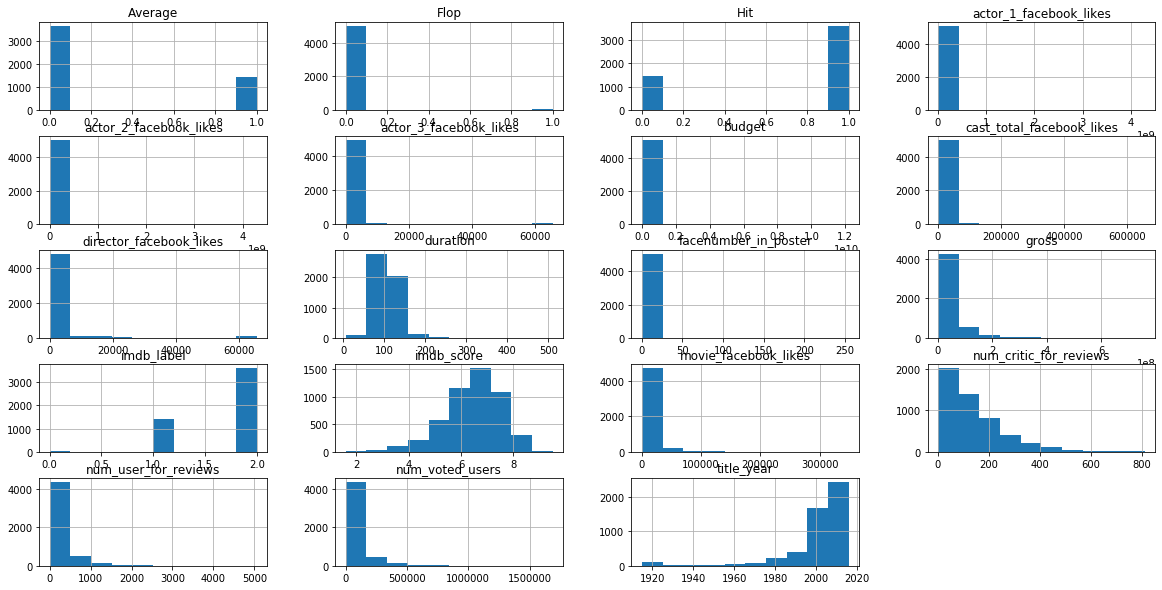

In [24]:
movie_metadata.hist(figsize = (20,10))

### Transforming the Genres feature 

In [25]:
#Transforming the genres feature to one hot encoded columns
def split_data(data, cols):
    data_series = list(data.apply(lambda x: np.array([y.strip() for y in x.split('|')])))
    for i in range(len(data_series)):
        row_length = len(data_series[i])
        if row_length<cols:
            for col in range(cols-row_length):
                data_series[i] = np.append(data_series[i], 'N/A')
    return data_series
def expand_data(data, cols, _list):
    data_series = pd.Series(split_data(data, cols))
    temp = []
    for item in _list:
        temp.append(data_series.apply(lambda x: 1 if item in x else 0))
    return temp            

In [26]:
genres = movie_metadata.genres.apply(lambda x: len(x.split('|'))).max()
print("Max Number of Genres for each movie : ", genres)

Max Number of Genres for each movie :  8


In [27]:
#Generating the list of unique Genres
genres_list=[]
for row in movie_metadata.genres.apply(lambda x: x.split('|')):
    for item in row:
        genres_list.append(item.strip())
genres_list = np.unique(np.array(genres_list, dtype = 'object'))
genres_list, genres_list.shape

(array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
        'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
        'Thriller', 'War', 'Western'], dtype=object), (26,))

In [28]:
#Adding the Genres features to the data
movie_metadata[genres_list] = pd.DataFrame(np.array(expand_data(movie_metadata['genres'], genres, 
                                                               genres_list)).T, columns=genres_list)
movie_metadata[genres_list]

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5039,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
5040,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5041,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
movie_metadata_stats = movie_metadata.describe().T
#Generating the IQR value to check the the outliers
movie_metadata_stats['IQR'] = movie_metadata_stats['75%'] - movie_metadata_stats['25%']

movie_metadata_stats['lower_iqr_boundary'] = movie_metadata_stats['25%']-1.5*movie_metadata_stats['IQR']
movie_metadata_stats['higher_iqr_boundary'] = movie_metadata_stats['75%']+1.5*movie_metadata_stats['IQR']
movie_metadata_stats

,count,mean,std,min,25%,50%,75%,max,IQR,lower_iqr_boundary,higher_iqr_boundary
num_critic_for_reviews,5043.0,1.388043e+02,1.217921e+02,0.0,48.0,109.0,194.0,8.130000e+02,146.0,-1.710000e+02,4.130000e+02
duration,5043.0,1.069001e+02,2.575656e+01,6.0,93.0,103.0,118.0,5.110000e+02,25.0,5.550000e+01,1.555000e+02
director_facebook_likes,5043.0,2.023857e+03,9.628337e+03,0.0,7.0,52.0,218.0,6.553500e+04,211.0,-3.095000e+02,5.345000e+02
actor_3_facebook_likes,5043.0,9.409586e+02,4.677610e+03,0.0,134.5,374.0,638.0,6.553500e+04,503.5,-6.207500e+02,1.393250e+03
actor_1_facebook_likes,5043.0,5.968235e+06,1.599209e+08,0.0,615.5,989.0,11000.0,4.294967e+09,10384.5,-1.496125e+04,2.657675e+04
gross,5043.0,3.997229e+07,6.483777e+07,161.0,303781.5,15279680.0,51357065.5,7.605058e+08,51053284.0,-7.627614e+07,1.279370e+08
num_voted_users,5043.0,8.366816e+04,1.384853e+05,5.0,8593.5,34359.0,96309.0,1.689764e+06,87715.5,-1.229798e+05,2.278822e+05
cast_total_facebook_likes,5043.0,9.699064e+03,1.816380e+04,0.0,1411.0,3090.0,13756.5,6.567300e+05,12345.5,-1.710725e+04,3.227475e+04
facenumber_in_poster,5043.0,2.024985e+00,1.301826e+01,0.0,0.0,1.0,2.0,2.550000e+02,2.0,-3.000000e+00,5.000000e+00
num_user_for_reviews,5043.0,2.716349e+02,3.776038e+02,0.0,64.0,155.0,324.0,5.060000e+03,260.0,-3.260000e+02,7.140000e+02


In [30]:
#Checking the Correlation of features
feature_correlation = movie_metadata.corr()
feature_correlation.style.background_gradient(cmap='coolwarm')

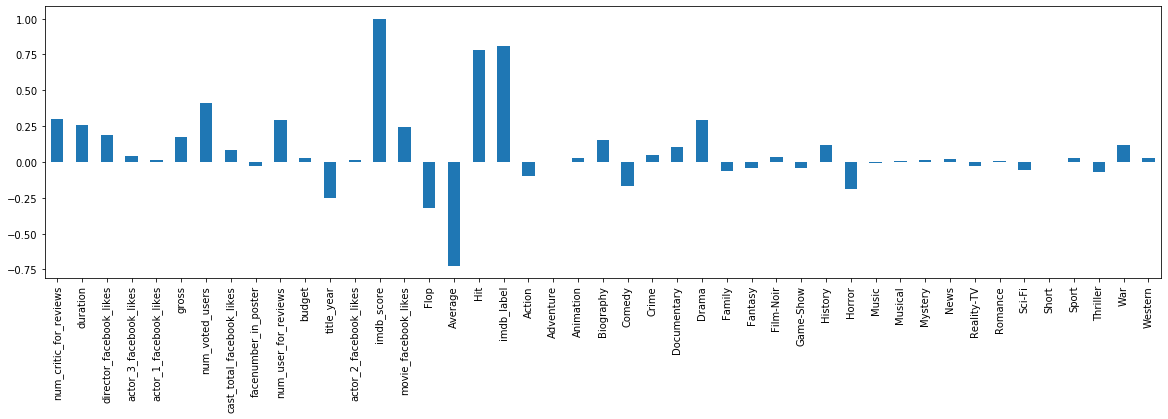

In [31]:
#Correlation with respect to the target variable
feature_correlation['imdb_score'].plot(kind='bar', figsize = (20,5))

In [32]:
#Reading the shape of the data
dataset_shape = movie_metadata.shape
dataset_shape

(5043, 57)

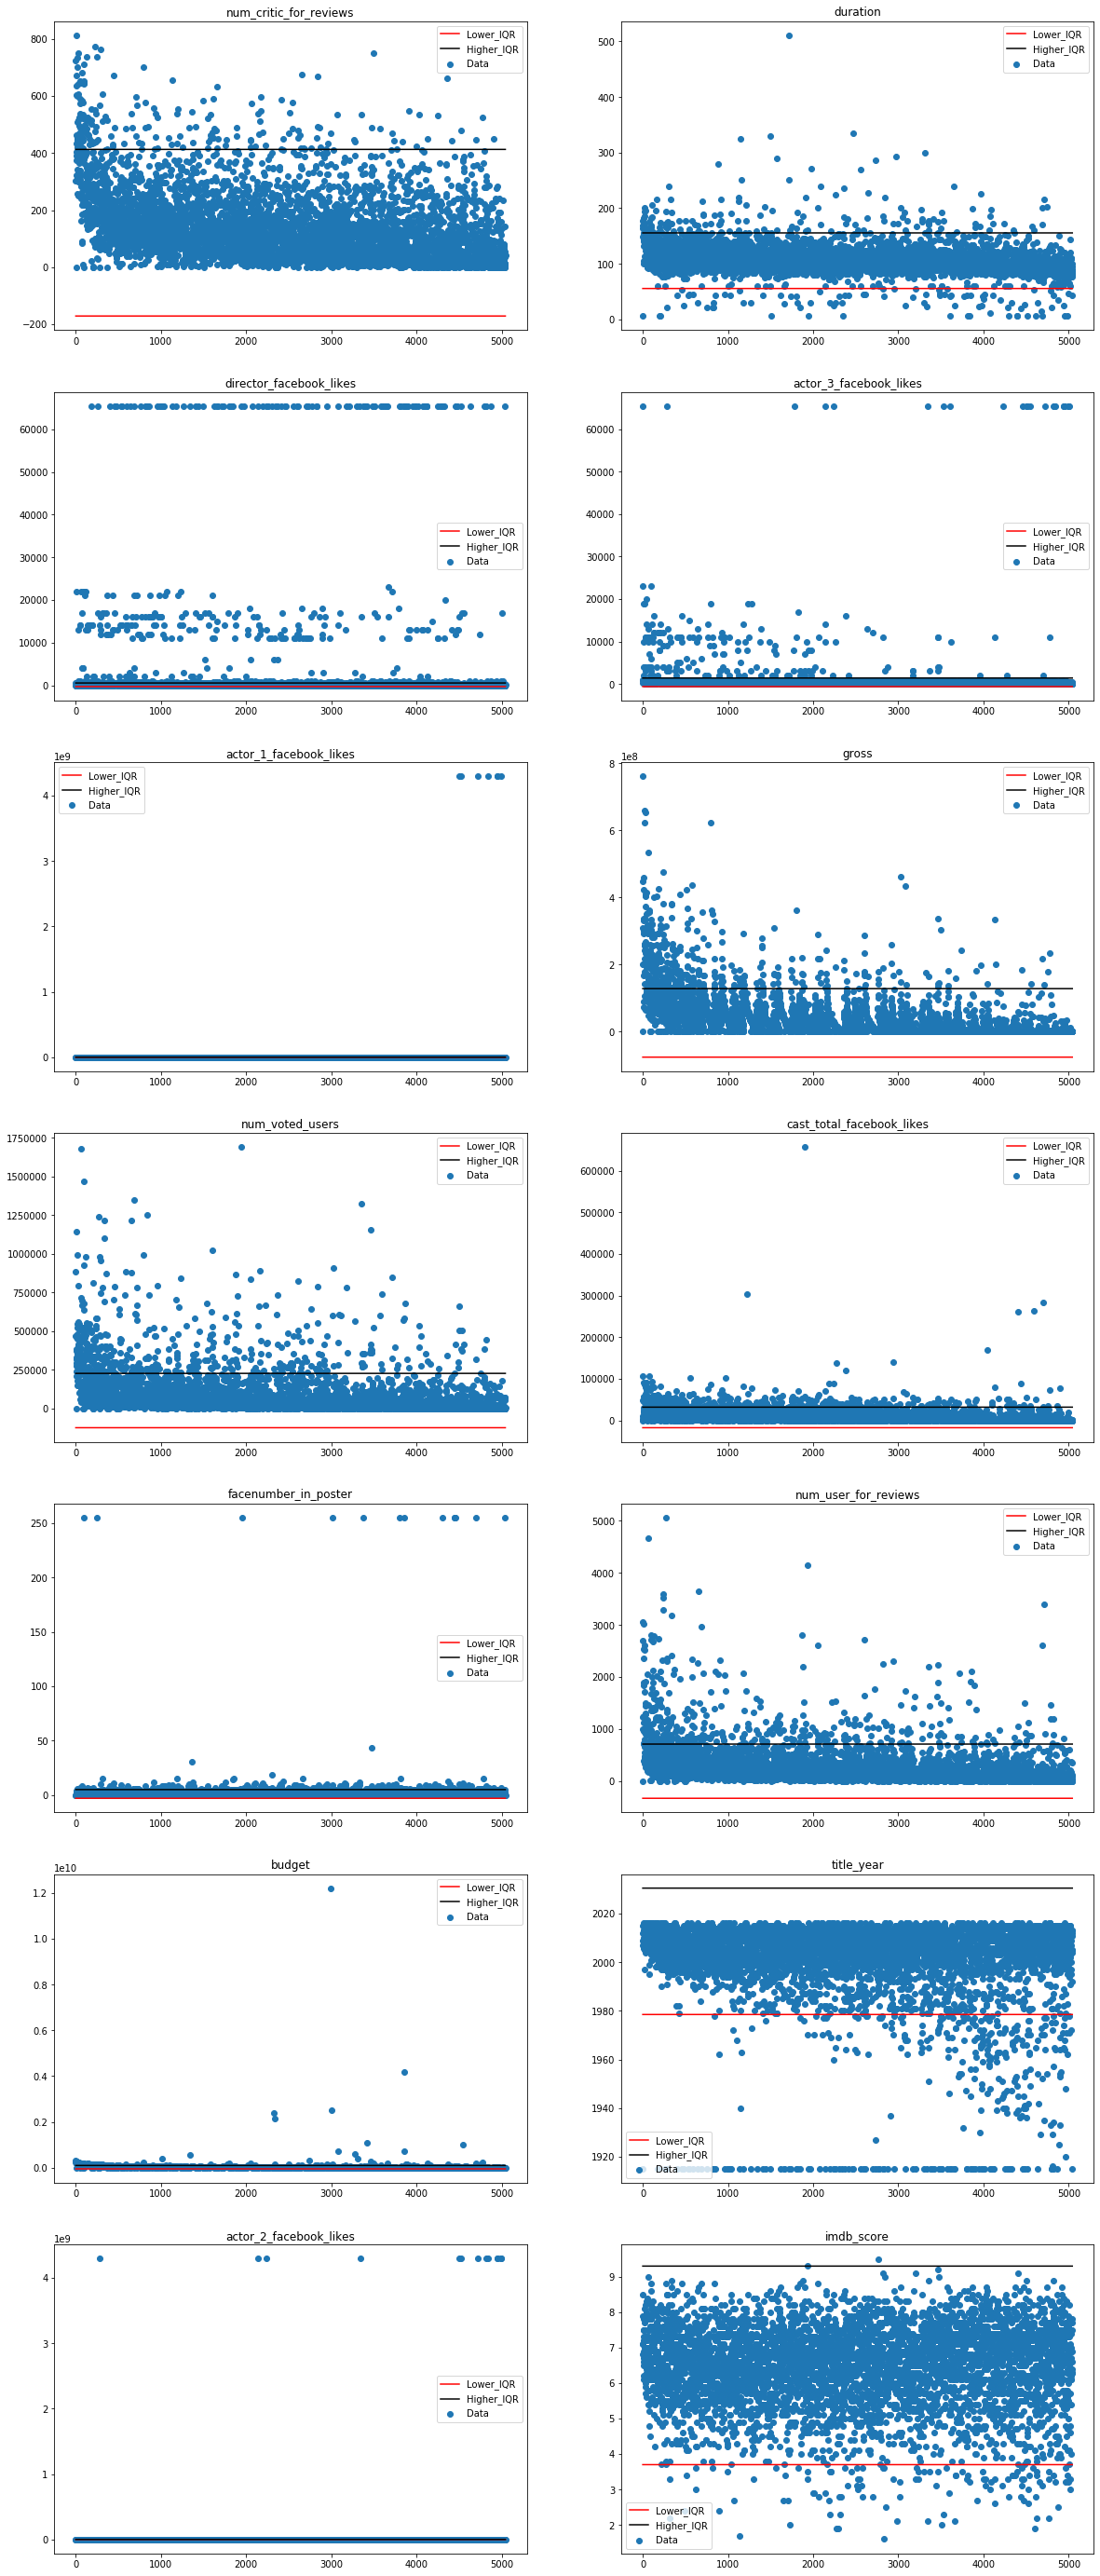

In [33]:
#Plotting the values of each feature
fig, ax = plt.subplots(len(numeric_features)//2, 2, figsize = (20,50))
for i in range(len(ax)):
    for j in range(len(ax[0])):
        #print(i, j, 2*i+j)
        ax[i][j].scatter(range(dataset_shape[0]), movie_metadata[numeric_features[2*i+j]])
        ax[i][j].plot(range(dataset_shape[0]), [movie_metadata_stats['lower_iqr_boundary'][numeric_features[2*i+j]] for _ in range(dataset_shape[0])], 
                      color = 'red')
        ax[i][j].plot(range(dataset_shape[0]), [movie_metadata_stats['higher_iqr_boundary'][numeric_features[2*i+j]] for _ in range(dataset_shape[0])], 
                      color = 'black')
        ax[i][j].legend(['Lower_IQR', 'Higher_IQR', 'Data'])
        ax[i][j].title.set_text(numeric_features[2*i+j])

In [34]:
#Checking the unique values in all categoricals Variables
movie_metadata[categorical_features].nunique()

color                2
director_name     2399
actor_2_name      3033
genres             914
actor_1_name      2098
movie_title       4917
actor_3_name      3522
language            48
country             66
content_rating      19
dtype: int64

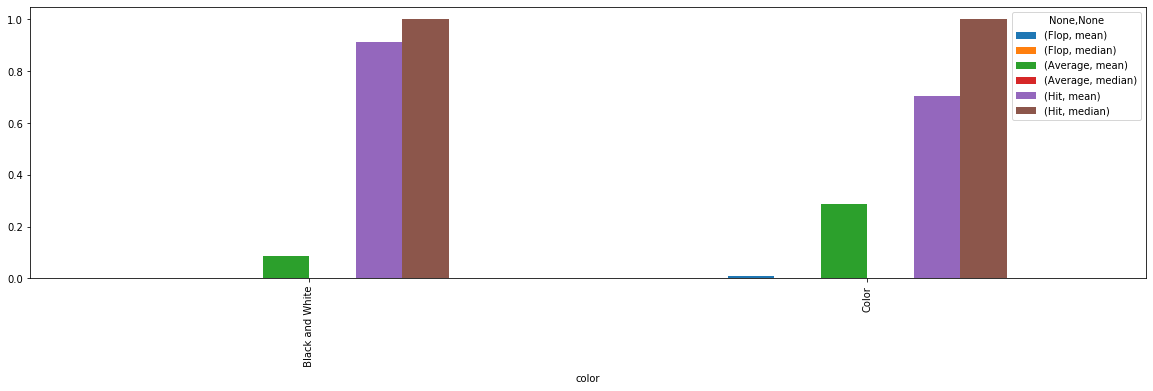

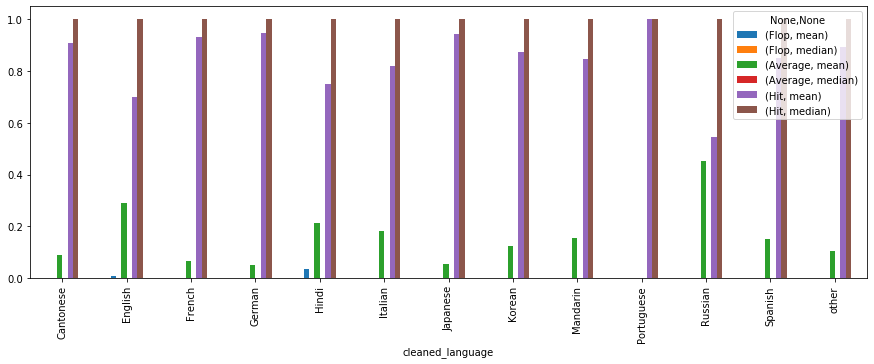

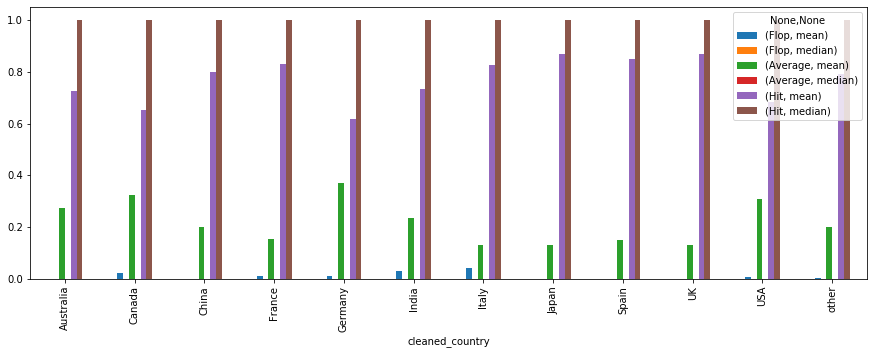

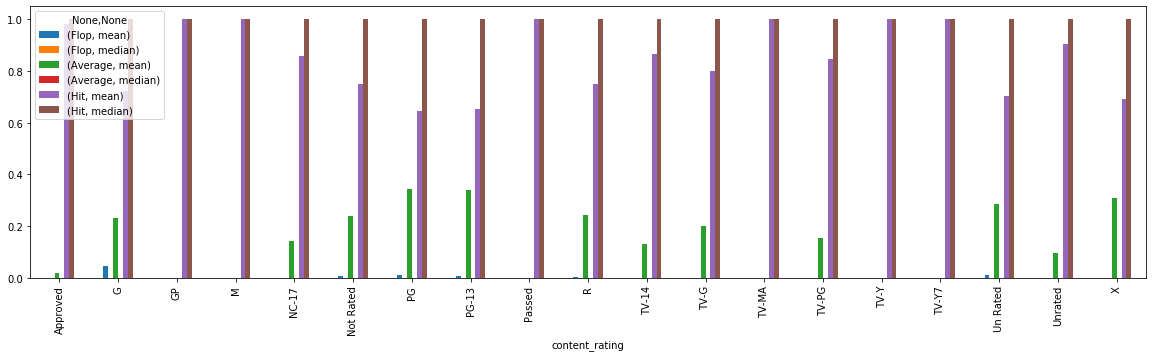

In [35]:
#Analysing the categorical Features with less uniwue values
movie_metadata.groupby('color')['Flop', 'Average', 'Hit'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))
movie_metadata.groupby('cleaned_language')['Flop', 'Average', 'Hit'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('cleaned_country')['Flop', 'Average', 'Hit'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('content_rating')['Flop', 'Average', 'Hit'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))

### Dropping the features which are not useful

In [36]:
movie_metadata.drop(['director_name', 'actor_2_name', 'genres', 'actor_1_name', 
                         'movie_title', 'actor_3_name', 'language', 'country'], axis=1, inplace = True)

In [37]:
categorical_features = movie_metadata.columns[movie_metadata.dtypes=='object']
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'title_year',
        'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 Index(['color', 'content_rating', 'cleaned_language', 'cleaned_country'], dtype='object'))

In [38]:
#Converting the categorical features into One hot encoded features
train_movie_data = pd.get_dummies(movie_metadata, columns = categorical_features)

In [39]:
#Updating the categorical_features variable
categorical_features = [feature for feature in train_movie_data.columns 
                        if feature not in numeric_features and feature not in ['Flop', 'Average', 'Hit', 'imdb_label']]

## Data Preprocessing 

### Scaling the Numerical features to (0,1) range

In [40]:
scaler = MinMaxScaler().fit(train_movie_data[train_numeric_features]) #Fitting the scaler with iput data
train_movie_data[train_numeric_features] = scaler.transform(train_movie_data[train_numeric_features]) # Transforming the iput data

In [41]:
X = train_movie_data[list(numeric_features)+categorical_features].drop('imdb_score', axis = 1)
Y = train_movie_data['imdb_label']

### Splitting data into Train and Validation sets

In [42]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, shuffle = True, test_size = 0.2)

## Analysing with Light Gradient Boosting Model (LGBM)

In [43]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class':3,
            'metric': {'multi_logloss'},
            'subsample': 0.7,
            'learning_rate': 0.005,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.9,
            'pos_bagging_fraction':0.5,
            'neg_bagging_fraction':0.5,
            'bagging_freq':10,
            'is_unbalance':True,
            'random_state':3,
            'verbose':2,
            'max_depth':10,
            'max_leaf_nodes':512
            }

lgb_train = lgb.Dataset(train_x, train_y, categorical_feature = categorical_features)
lgb_eval = lgb.Dataset(test_x, test_y, categorical_feature = categorical_features)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=200,
               verbose_eval = 200)
    

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.432915	valid_1's multi_logloss: 0.480082
[400]	training's multi_logloss: 0.34672	valid_1's multi_logloss: 0.426188
[600]	training's multi_logloss: 0.294601	valid_1's multi_logloss: 0.400452
[800]	training's multi_logloss: 0.257051	valid_1's multi_logloss: 0.385409
[1000]	training's multi_logloss: 0.227999	valid_1's multi_logloss: 0.37614
[1200]	training's multi_logloss: 0.204345	valid_1's multi_logloss: 0.369933
[1400]	training's multi_logloss: 0.184668	valid_1's multi_logloss: 0.366412
[1600]	training's multi_logloss: 0.167906	valid_1's multi_logloss: 0.364984
[1800]	training's multi_logloss: 0.153064	valid_1's multi_logloss: 0.364405
[2000]	training's multi_logloss: 0.139838	valid_1's multi_logloss: 0.364855
Early stopping, best iteration is:
[1841]	training's multi_logloss: 0.150284	valid_1's multi_logloss: 0.364235


In [44]:
train_pred = np.argmax(gbm.predict(train_x), axis=1)
test_pred = np.argmax(gbm.predict(test_x), axis=1)

In [45]:
print("Train Score : ", f1_score(train_pred, train_y, average = 'macro'))
print("Test Score : ", f1_score(test_pred, test_y, average = 'macro'))

Train Score :  0.9794636125987073
Test Score :  0.5295798611111112


### Plotting The feature importance as per LGBM Model

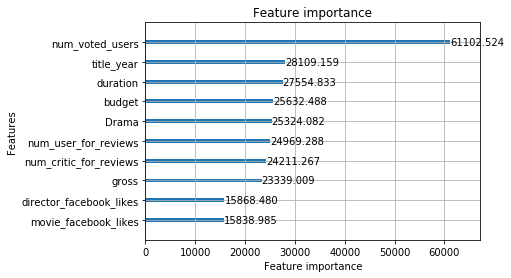

In [46]:
lgb.plot_importance(gbm, importance_type = 'gain', max_num_features = 10)

### Confusion Matrix for LGBM Model

In [47]:
print("Confusion Matrix : ", confusion_matrix(np.argmax(gbm.predict(X), axis=1), Y), sep = '\n')

Confusion Matrix : 
[[  35    0    0]
 [   5 1241   80]
 [   1  172 3509]]


### Plotting Predicted Data vs Actual data

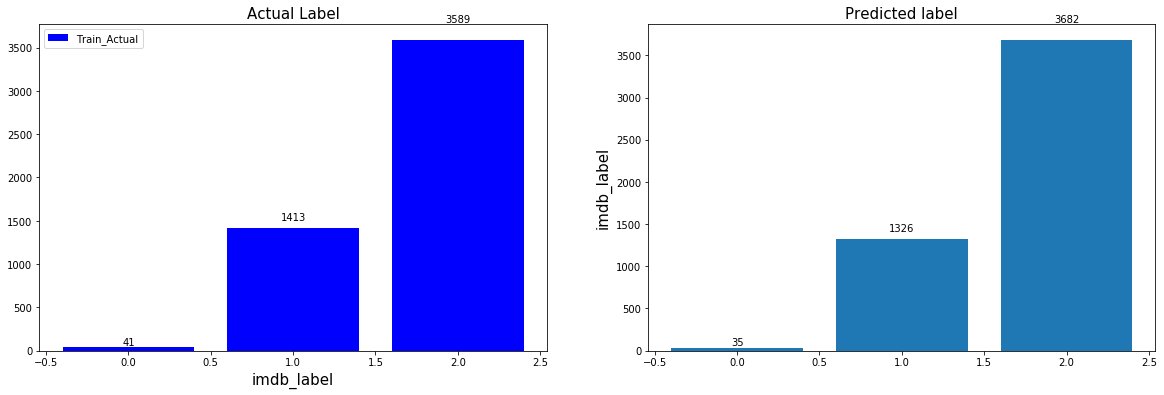

In [48]:
actual_counts = np.unique(Y, return_counts = True)
predicted_counts = np.unique(np.argmax(gbm.predict(X), axis=1), return_counts = True)
fig, ax = plt.subplots(1, 2, figsize = (20,6))
rects = ax[0].bar(actual_counts[0], actual_counts[1], color = 'blue')
ax[0].set_title("Actual Label", fontdict={'fontsize':15})
ax[0].set_xlabel("imdb_label", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
for rect in rects:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')
rects = ax[1].bar(predicted_counts[0], predicted_counts[1])
ax[1].set_title("Predicted label", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')

## Analysing with Extra Trees Classification Model

In [49]:
et = ExtraTreesClassifier(bootstrap = True, max_depth = 16, max_leaf_nodes = 256, random_state = 3, 
                         verbose = 1, oob_score = 'f1', criterion = 'entropy', n_jobs = -1, 
                         n_estimators = 300)
et.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=16, max_features='auto',
                     max_leaf_nodes=256, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                     oob_score='f1', random_state=3, verbose=1,
                     warm_start=False)

In [50]:
print("F1 Score : ", f1_score(et.predict(train_x), train_y, average = 'macro'))
print("F1 Score : ", f1_score(et.predict(test_x), test_y, average = 'macro'))
et.score(train_x, train_y), et.score(test_x, test_y)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


F1 Score :  0.6507382773637763
F1 Score :  0.46604986095563855


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


(0.8730788299454636, 0.7928642220019821)

### The important features as per Extra Trees Classification Model

In [51]:
print("Important Features : ", test_x.columns[et.feature_importances_>0.05])

Important Features :  Index(['num_critic_for_reviews', 'num_voted_users', 'Drama'], dtype='object')


### Confusion Matrix for Extra Trees Classification Model

In [52]:
print("Confusion Matrix : ", confusion_matrix(et.predict(X), Y), sep = '\n')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


Confusion Matrix : 
[[   6    0    0]
 [  24  833  106]
 [  11  580 3483]]


### Plotting Predicted Data vs Actual data

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


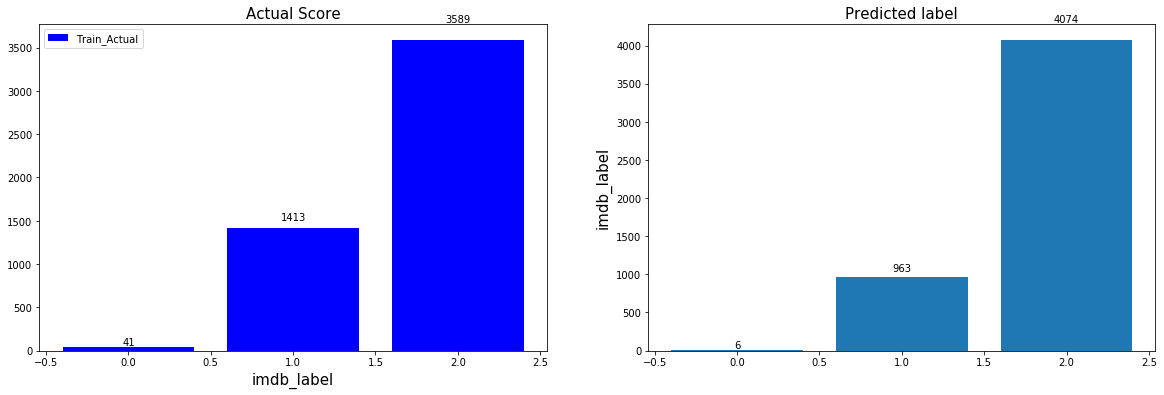

In [53]:
actual_counts = np.unique(Y, return_counts = True)
predicted_counts = np.unique(et.predict(X), return_counts = True)
fig, ax = plt.subplots(1, 2, figsize = (20,6))
rects = ax[0].bar(actual_counts[0], actual_counts[1], color = 'blue')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_xlabel("imdb_label", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
for rect in rects:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')
rects = ax[1].bar(predicted_counts[0], predicted_counts[1])
ax[1].set_title("Predicted label", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')

## Analysing with Random Forest Classification Model

In [54]:
rf = RandomForestClassifier(max_depth = 10, max_features = None, max_leaf_nodes = 512, random_state = 3, 
                           verbose = 1, n_estimators = 300, oob_score = 'f1', n_jobs = -1)
rf.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=None,
                       max_leaf_nodes=512, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score='f1', random_state=3, verbose=1,
                       warm_start=False)

In [55]:
print("F1 Score : ", f1_score(rf.predict(train_x), train_y, average = 'macro'))
print("F1 Score : ", f1_score(rf.predict(test_x), test_y, average = 'macro'))
rf.score(train_x, train_y), rf.score(test_x, test_y)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


F1 Score :  0.7581285391438225
F1 Score :  0.5111267331112673


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


(0.9578582052553297, 0.8225966303270565)

### The important features as per Random Forest Classification Model

In [56]:
print("Important Features : ", test_x.columns[rf.feature_importances_>0.05])

Important Features :  Index(['duration', 'gross', 'num_voted_users', 'num_user_for_reviews',
       'budget', 'title_year', 'Drama'],
      dtype='object')


### Confusion Matrix as per Random Forest Classification Model

In [57]:
print("Confusion Matrix : ", confusion_matrix(rf.predict(X), Y), sep = '\n')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


Confusion Matrix : 
[[   8    0    0]
 [  28 1238  141]
 [   5  175 3448]]


### Plotting Predicted Data vs Actual data

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


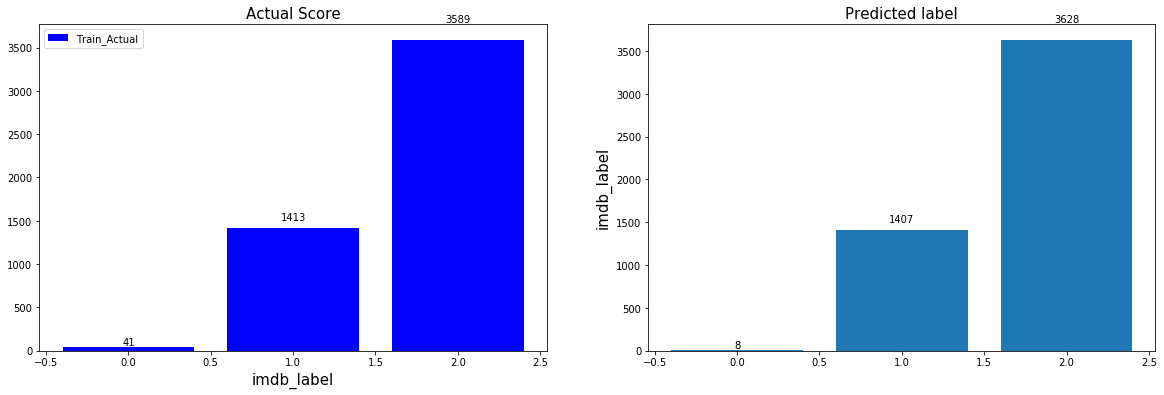

In [58]:
actual_counts = np.unique(Y, return_counts = True)
predicted_counts = np.unique(rf.predict(X), return_counts = True)
fig, ax = plt.subplots(1, 2, figsize = (20,6))
rects = ax[0].bar(actual_counts[0], actual_counts[1], color = 'blue')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_xlabel("imdb_label", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
for rect in rects:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')
rects = ax[1].bar(predicted_counts[0], predicted_counts[1])
ax[1].set_title("Predicted label", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')

## Analysing with Gradient Boosting Classification Model

In [59]:
gbr = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 7, max_leaf_nodes = 64, 
                                random_state = 3, verbose = 2, n_estimators = 2000, subsample = 0.8, 
                                n_iter_no_change = 5, validation_fraction = 0.2, tol = 1e-5)
gbr.fit(train_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1529.2348          11.1173            2.13m
         2        1468.9532          11.2771            1.88m
         3        1392.3752          10.1589            1.95m
         4        1340.3472           8.6631            2.02m
         5        1287.1766           6.5356            1.99m
         6        1246.7393           6.1435            2.00m
         7        1205.6484           6.6753            1.97m
         8        1169.6879           5.8921            2.05m
         9        1121.2166           5.3614            2.02m
        10        1091.2429           3.8797            1.99m
        11        1058.5358           4.2449            1.99m
        12        1035.5731           3.6974            2.03m
        13         983.8103           3.6433            2.00m
        14         958.2118           2.5068            2.00m
        15         946.3919           3.8382            2.02m
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=64,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=3, subsample=0.8, tol=1e-05,
                           validation_fraction=0.2, verbose=2,
                           warm_start=False)

In [60]:
print("F1 Score : ", f1_score(gbr.predict(train_x), train_y, average = 'macro'))
print("F1 Score : ", f1_score(gbr.predict(test_x), test_y, average = 'macro'))
gbr.score(train_x, train_y), gbr.score(test_x, test_y)

F1 Score :  0.9231626426468235
F1 Score :  0.5140099364237295


(0.9519087754090233, 0.8265609514370664)

### The important features as per Gradient Boosting Classification Model

In [61]:
print("Important Features : ", test_x.columns[gbr.feature_importances_>0.05])

Important Features :  Index(['num_critic_for_reviews', 'duration', 'gross', 'num_voted_users',
       'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
       'title_year', 'Drama'],
      dtype='object')


### The Confusion Matrix for Gradient Boosting Classification Model

In [62]:
print("Confusion Matrix : ", confusion_matrix(gbr.predict(X), Y), sep = '\n')

Confusion Matrix : 
[[  28    0    0]
 [   8 1168  111]
 [   5  245 3478]]


### Plotting Predicted Data vs Actual data

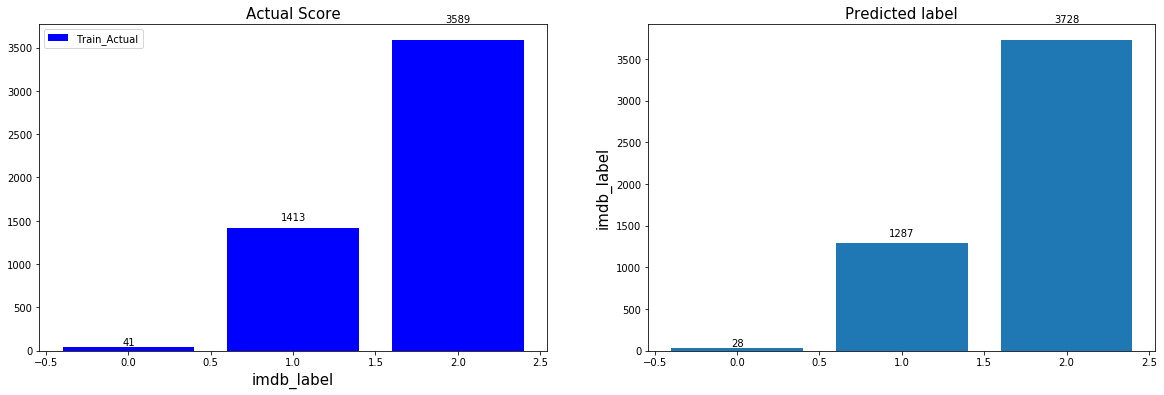

In [63]:
actual_counts = np.unique(Y, return_counts = True)
predicted_counts = np.unique(gbr.predict(X), return_counts = True)
fig, ax = plt.subplots(1, 2, figsize = (20,6))
rects = ax[0].bar(actual_counts[0], actual_counts[1], color = 'blue')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_xlabel("imdb_label", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
for rect in rects:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')
rects = ax[1].bar(predicted_counts[0], predicted_counts[1])
ax[1].set_title("Predicted label", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')

## Analysing with Histogram based Gradient Boosting Classification Model

In [64]:
hgbr = HistGradientBoostingClassifier(max_depth = 16, max_leaf_nodes = 512, scoring = ['f1', 'roc_auc'], 
                                     l2_regularization = 0.001, random_state = 3, verbose = 2, validation_fraction = 0.2, 
                                    max_iter = 50)
hgbr.fit(train_x, train_y)

Binning 0.003 GB of training data: 0.019 s
Fitting gradient boosted rounds:
[1/50] 3 trees, 258 leaves (86 on avg), max depth = 15, in 0.312s
[2/50] 3 trees, 293 leaves (97 on avg), max depth = 16, in 0.326s
[3/50] 3 trees, 298 leaves (99 on avg), max depth = 16, in 0.407s
[4/50] 3 trees, 315 leaves (105 on avg), max depth = 16, in 0.379s
[5/50] 3 trees, 317 leaves (105 on avg), max depth = 16, in 0.442s
[6/50] 3 trees, 304 leaves (101 on avg), max depth = 16, in 0.344s
[7/50] 3 trees, 303 leaves (101 on avg), max depth = 16, in 0.410s
[8/50] 3 trees, 309 leaves (103 on avg), max depth = 16, in 0.347s
[9/50] 3 trees, 312 leaves (104 on avg), max depth = 16, in 0.364s
[10/50] 3 trees, 318 leaves (106 on avg), max depth = 16, in 0.588s
[11/50] 3 trees, 310 leaves (103 on avg), max depth = 16, in 0.332s
[12/50] 3 trees, 309 leaves (103 on avg), max depth = 16, in 0.410s
[13/50] 3 trees, 308 leaves (102 on avg), max depth = 16, in 0.347s
[14/50] 3 trees, 307 leaves (102 on avg), max depth 

HistGradientBoostingClassifier(l2_regularization=0.001, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=16,
                               max_iter=50, max_leaf_nodes=512,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=3, scoring=['f1', 'roc_auc'],
                               tol=1e-07, validation_fraction=0.2, verbose=2,
                               warm_start=False)

In [65]:
print("F1 Score : ", f1_score(hgbr.predict(train_x), train_y, average='macro'))
print("F1 Score : ", f1_score(hgbr.predict(test_x), test_y, average='macro'))
hgbr.score(train_x, train_y), hgbr.score(test_x, test_y)

F1 Score :  1.0
F1 Score :  0.6304916968213227


(1.0, 0.848364717542121)

### The Confusion Matrix for Histogram based Gradient Boosting Classification Model

In [66]:
print("Confusion Matrix : ", confusion_matrix(hgbr.predict(X), Y), sep = '\n')

Confusion Matrix : 
[[  36    0    0]
 [   4 1313   48]
 [   1  100 3541]]


### Plotting Predicted Data vs Actual data

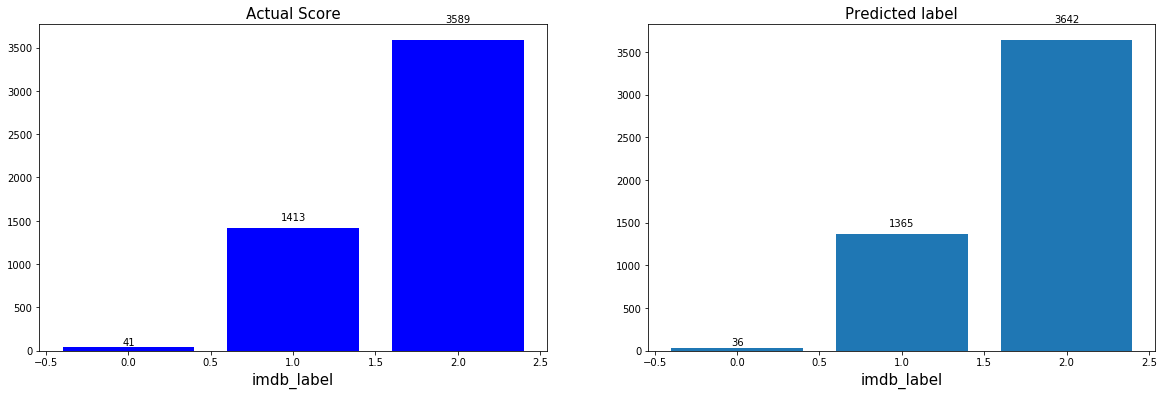

In [67]:
actual_counts = np.unique(Y, return_counts = True)
predicted_counts = np.unique(hgbr.predict(X), return_counts = True)
fig, ax = plt.subplots(1, 2, figsize = (20,6))
rects = ax[0].bar(actual_counts[0], actual_counts[1], color = 'blue')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_xlabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')
rects = ax[1].bar(predicted_counts[0], predicted_counts[1])
ax[1].set_title("Predicted label", fontdict={'fontsize':15})
ax[1].set_xlabel("imdb_label", fontdict={'fontsize':15})
for rect in rects:
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
        ha='center', va='bottom')